(mmm_evaluation)=
# Model Evaluation in PyMC-Marketing

This notebook demonstrates how to evaluate Marketing Mix Models using PyMC-Marketing's evaluation metrics and functions. We'll cover:

1. Standard evaluation metrics (RMSE, MAE, MAPE)
2. Normalized metrics (NRMSE, NMAE)
3. Calculating and visualizing metric distributions and summaries of those distributions
4. Creating evaluation plots (prior vs posterior plots)

First, let's import the necessary libraries:

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    root_mean_squared_error,
)

from pymc_marketing.mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.evaluation import (
    calculate_metric_distributions,
    compute_summary_metrics,
    summarize_metric_distributions,
)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm-evaluation"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
hdi_prob: float = 0.89  # change this to whatever HDI you want

## Setting up a Demo Model

Let's first create a simple MMM model using the example dataset:

In [3]:
# Load example data
data_url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
data = pd.read_csv(data_url, parse_dates=["date_week"])

X = data.drop("y", axis=1)
y = data["y"]

# Create and fit the model
mmm = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    yearly_seasonality=2,
)

fit_kwargs = {
    "tune": 1_500,
    "chains": 4,
    "draws": 2_000,
    "nuts_sampler": "numpyro",
    "target_accept": 0.92,
    "random_seed": rng,
}
_ = mmm.fit(X, y, **fit_kwargs)

# Generate posterior predictive samples
posterior_preds = mmm.sample_posterior_predictive(X, random_seed=rng)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling: [y]


Output()

## Understanding the Evaluation Metrics

PyMC-Marketing provides several metrics for evaluating your models:

1. Standard metrics from scikit-learn:
   - RMSE (Root Mean Squared Error)
   - MAE (Mean Absolute Error)
   - MAPE (Mean Absolute Percentage Error)

2. Bayesian R-Squared (from `arviz.az.r2_score`)

3. Normalized metrics:
   - NRMSE (Normalized Root Mean Squared Error), such as is used by Robyn
   - NMAE (Normalized Mean Absolute Error)

Let's calculate these metrics for our model:

In [4]:
# Calculate metrics for all posterior samples
results = compute_summary_metrics(
    y_true=mmm.y,
    y_pred=posterior_preds.y.to_numpy(),
    metrics_to_calculate=[
        "r_squared",
        "rmse",
        "nrmse",
        "mae",
        "nmae",
        "mape",
    ],
    hdi_prob=hdi_prob,
)

# Print results in a formatted way
for metric, stats in results.items():
    print(f"\n{metric.upper()}:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.4f}")


R_SQUARED:
  mean: 0.9057
  median: 0.9062
  std: 0.0100
  min: 0.8605
  max: 0.9343
  89%_hdi_lower: 0.8902
  89%_hdi_upper: 0.9217

RMSE:
  mean: 351.3628
  median: 350.5780
  std: 19.7836
  min: 286.7718
  max: 431.5480
  89%_hdi_lower: 320.3752
  89%_hdi_upper: 382.8984

NRMSE:
  mean: 0.0686
  median: 0.0685
  std: 0.0039
  min: 0.0560
  max: 0.0843
  89%_hdi_lower: 0.0626
  89%_hdi_upper: 0.0748

MAE:
  mean: 281.3655
  median: 280.6294
  std: 16.6181
  min: 223.4076
  max: 346.8520
  89%_hdi_lower: 256.0472
  89%_hdi_upper: 308.4454

NMAE:
  mean: 0.0550
  median: 0.0548
  std: 0.0032
  min: 0.0436
  max: 0.0678
  89%_hdi_lower: 0.0500
  89%_hdi_upper: 0.0602

MAPE:
  mean: 0.0556
  median: 0.0554
  std: 0.0033
  min: 0.0443
  max: 0.0683
  89%_hdi_lower: 0.0503
  89%_hdi_upper: 0.0608


`compute_summary_metrics` actually combines the steps of two other functions:

1. `calculate_metric_distributions`
2. `summarize_metric_distributions`

The metric distributions (unsummarised) can sometimes be useful on their own, e.g. if you'd like to visualise the distribution of a metric.

In [5]:
# Calculate distributions for multiple metrics
metric_distributions = calculate_metric_distributions(
    y_true=mmm.y,
    y_pred=posterior_preds.y.to_numpy(),
    metrics_to_calculate=["rmse", "mae", "r_squared"],
)

# Summarize the distributions
summaries = summarize_metric_distributions(metric_distributions, hdi_prob=0.89)

# Create a nice display of the summaries
for metric, summary in summaries.items():
    print(f"\n{metric.upper()} Summary:")
    print(f"  Mean: {summary['mean']:.4f}")
    print(f"  Median: {summary['median']:.4f}")
    print(f"  Standard Deviation: {summary['std']:.4f}")
    print(
        f"  89% HDI: [{summary['89%_hdi_lower']:.4f}, {summary['89%_hdi_upper']:.4f}]"
    )


RMSE Summary:
  Mean: 351.3628
  Median: 350.5780
  Standard Deviation: 19.7836
  89% HDI: [320.3752, 382.8984]

MAE Summary:
  Mean: 281.3655
  Median: 280.6294
  Standard Deviation: 16.6181
  89% HDI: [256.0472, 308.4454]

R_SQUARED Summary:
  Mean: 0.9057
  Median: 0.9062
  Standard Deviation: 0.0100
  89% HDI: [0.8902, 0.9217]


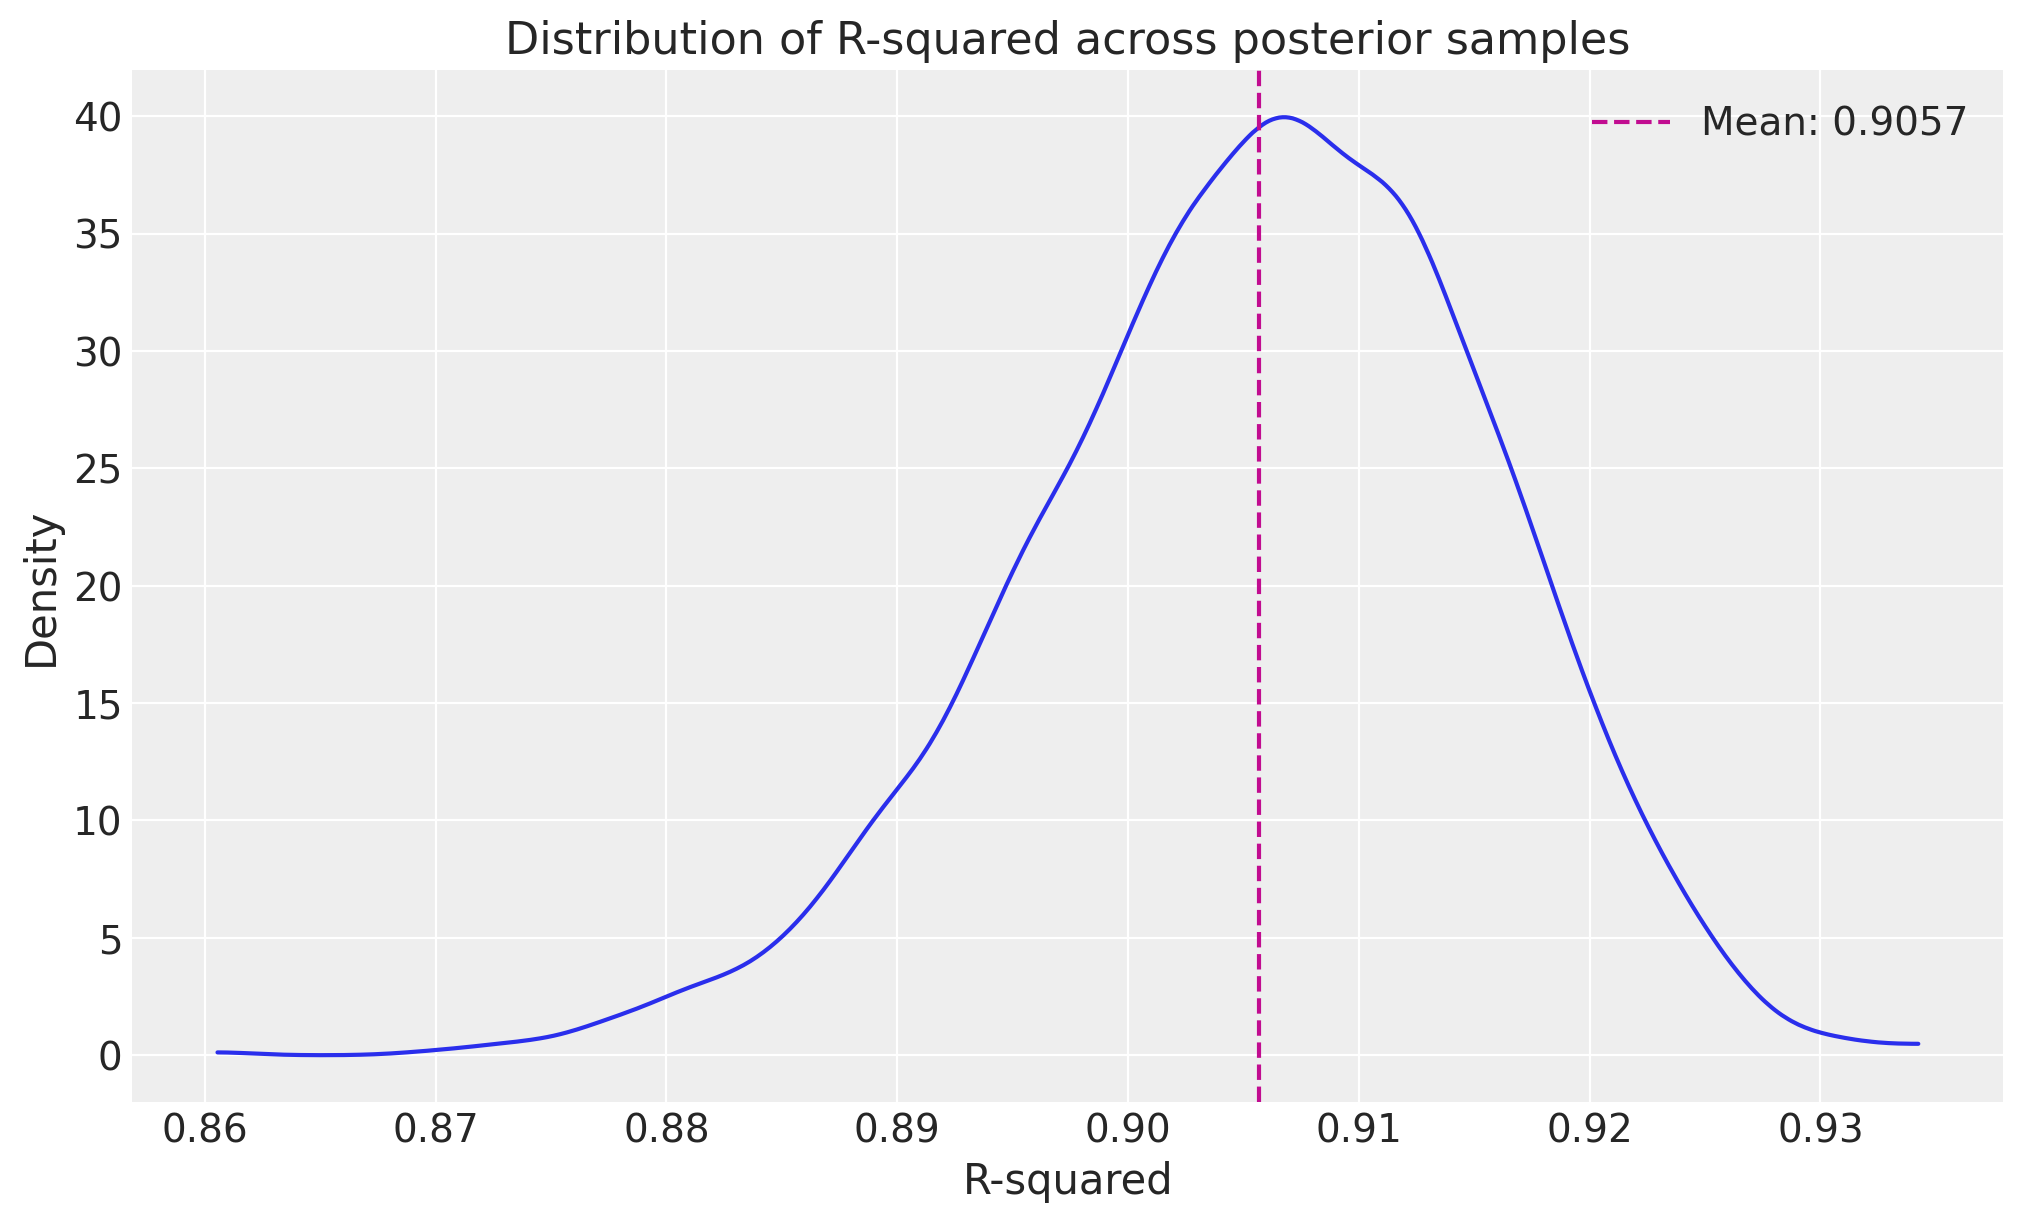

In [6]:
# Visualise the distribution of R-squared
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_dist(metric_distributions["r_squared"], color="C0", ax=ax)
ax.axvline(
    summaries["r_squared"]["mean"],
    color="C3",
    linestyle="--",
    label=f"Mean: {metric_distributions['r_squared'].mean():.4f}",
)
ax.set_title("Distribution of R-squared across posterior samples")
ax.set_xlabel("R-squared")
ax.set_ylabel("Density")
ax.legend();

## Understanding Metric Distributions in Bayesian Models

In Bayesian modeling, we tend to work with distributions rather than point estimates. This is particularly important for model evaluation metrics because:

1. **E[f(x)] is not guaranteed to be f(E[x])**: This means calculating metrics on mean predictions can give different (and potentially misleading) results compared to calculating the distribution of metrics across posterior samples.

2. **Uncertainty Quantification**: Having distributions of metrics allows us to understand the uncertainty in our model's performance.

Let's demonstrate this with an example:

RMSE calculated on mean predictions: 237.8336
Mean of RMSE distribution: 351.3628


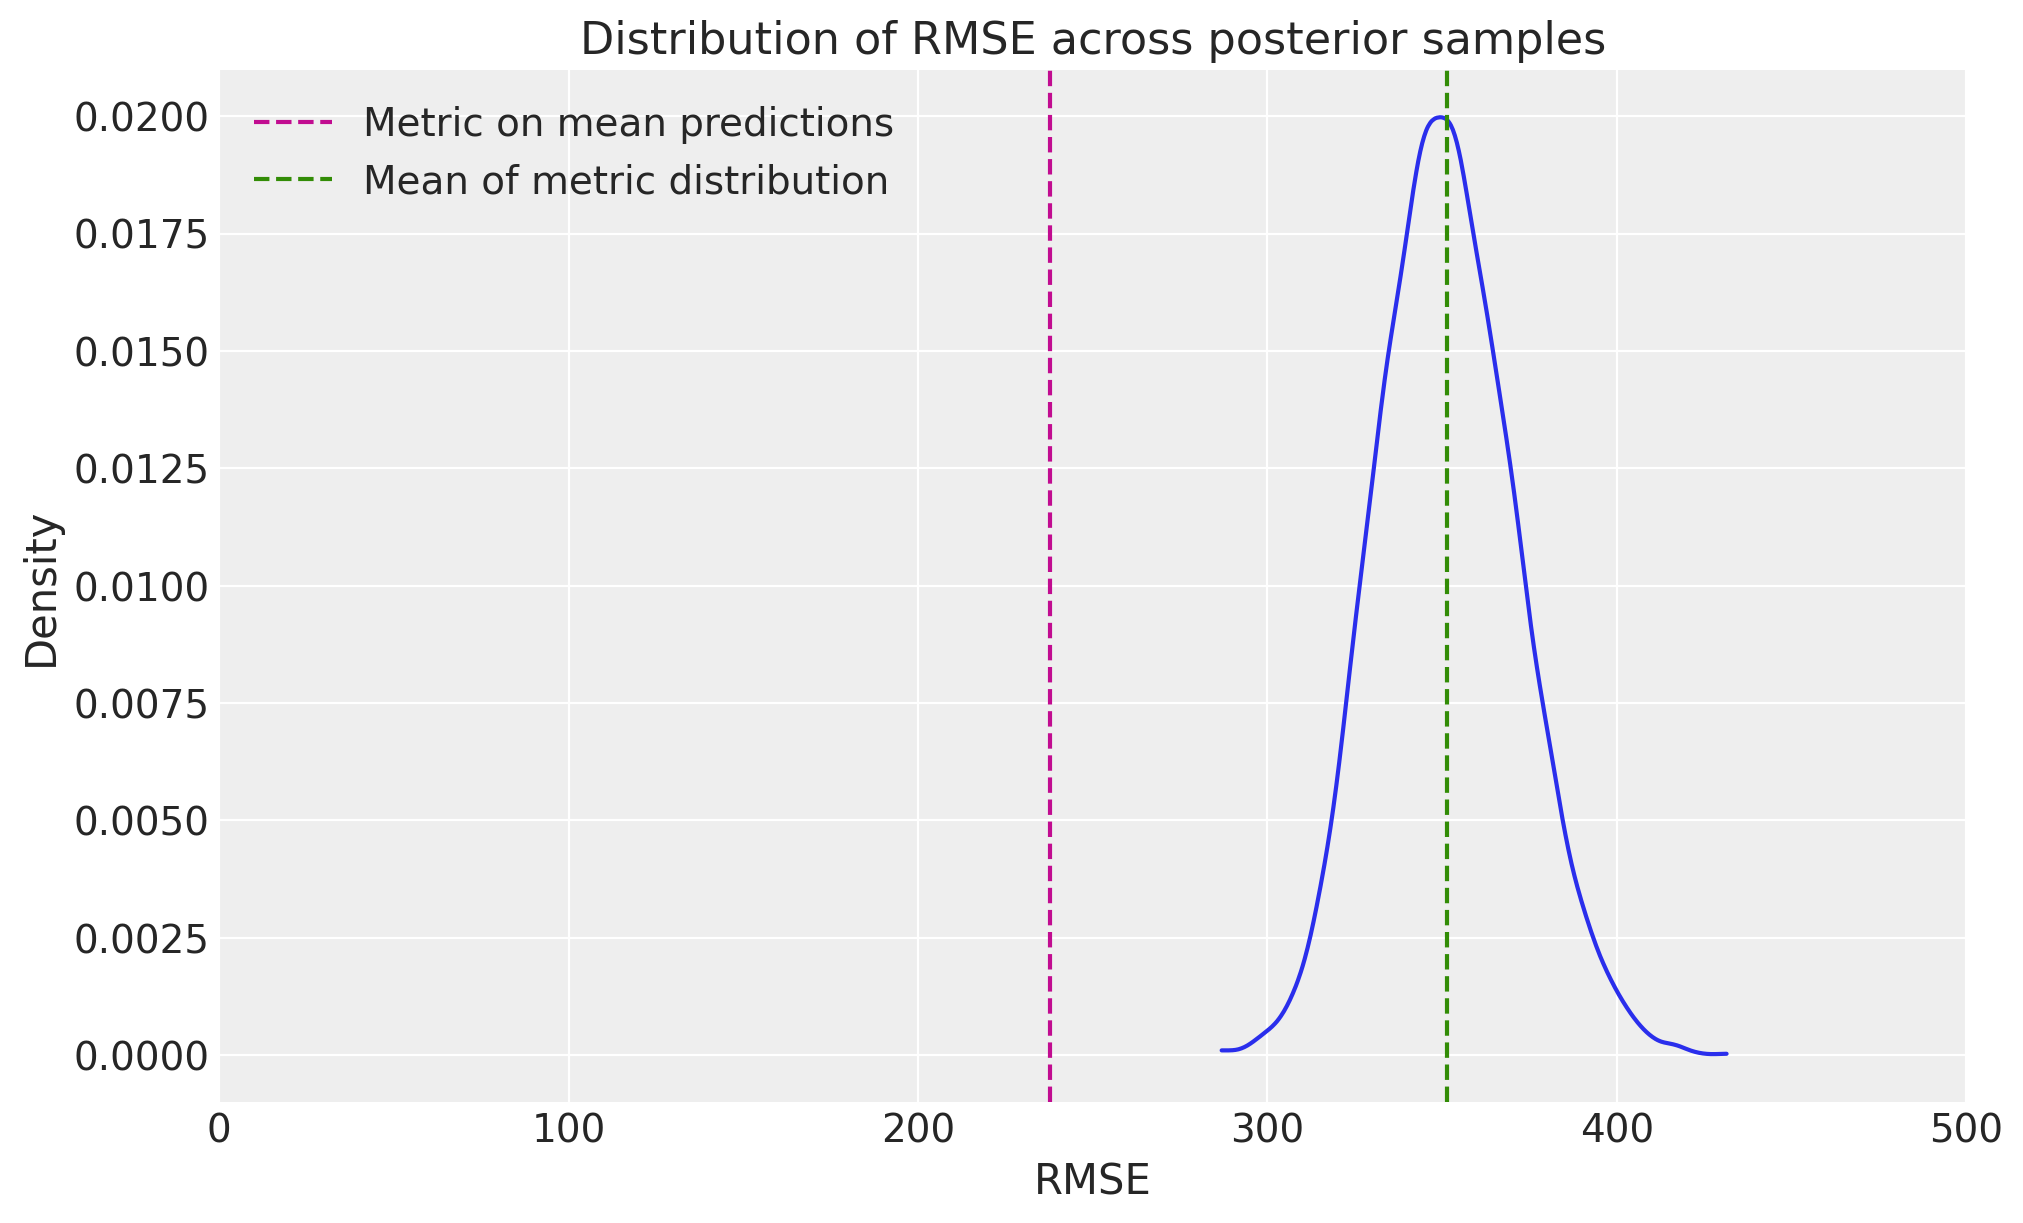

In [7]:
# Wrong way: Calculate metrics using mean predictions
mean_predictions = posterior_preds.y.mean(axis=1)
naive_rmse = root_mean_squared_error(mmm.y, mean_predictions)

# Correct way: Calculate distribution of metrics
metric_distributions = calculate_metric_distributions(
    y_true=mmm.y, y_pred=posterior_preds.y, metrics_to_calculate=["rmse"]
)

proper_rmse_mean = metric_distributions["rmse"].mean()

print(f"RMSE calculated on mean predictions: {naive_rmse:.4f}")
print(f"Mean of RMSE distribution: {proper_rmse_mean:.4f}")

# Visualize the RMSE distribution
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_dist(metric_distributions["rmse"], color="C0", ax=ax)
ax.axvline(naive_rmse, color="C3", linestyle="--", label="Metric on mean predictions")
ax.axvline(
    proper_rmse_mean, color="C2", linestyle="--", label="Mean of metric distribution"
)
ax.set_title("Distribution of RMSE across posterior samples")
ax.set_xlim(0, 500)
ax.set_xlabel("RMSE")
ax.set_ylabel("Density")
ax.legend();

## Comparing Prior vs Posterior Distributions

We can also visualize how our prior beliefs compare to the posterior distributions using the `plot_prior_vs_posterior` method:

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]


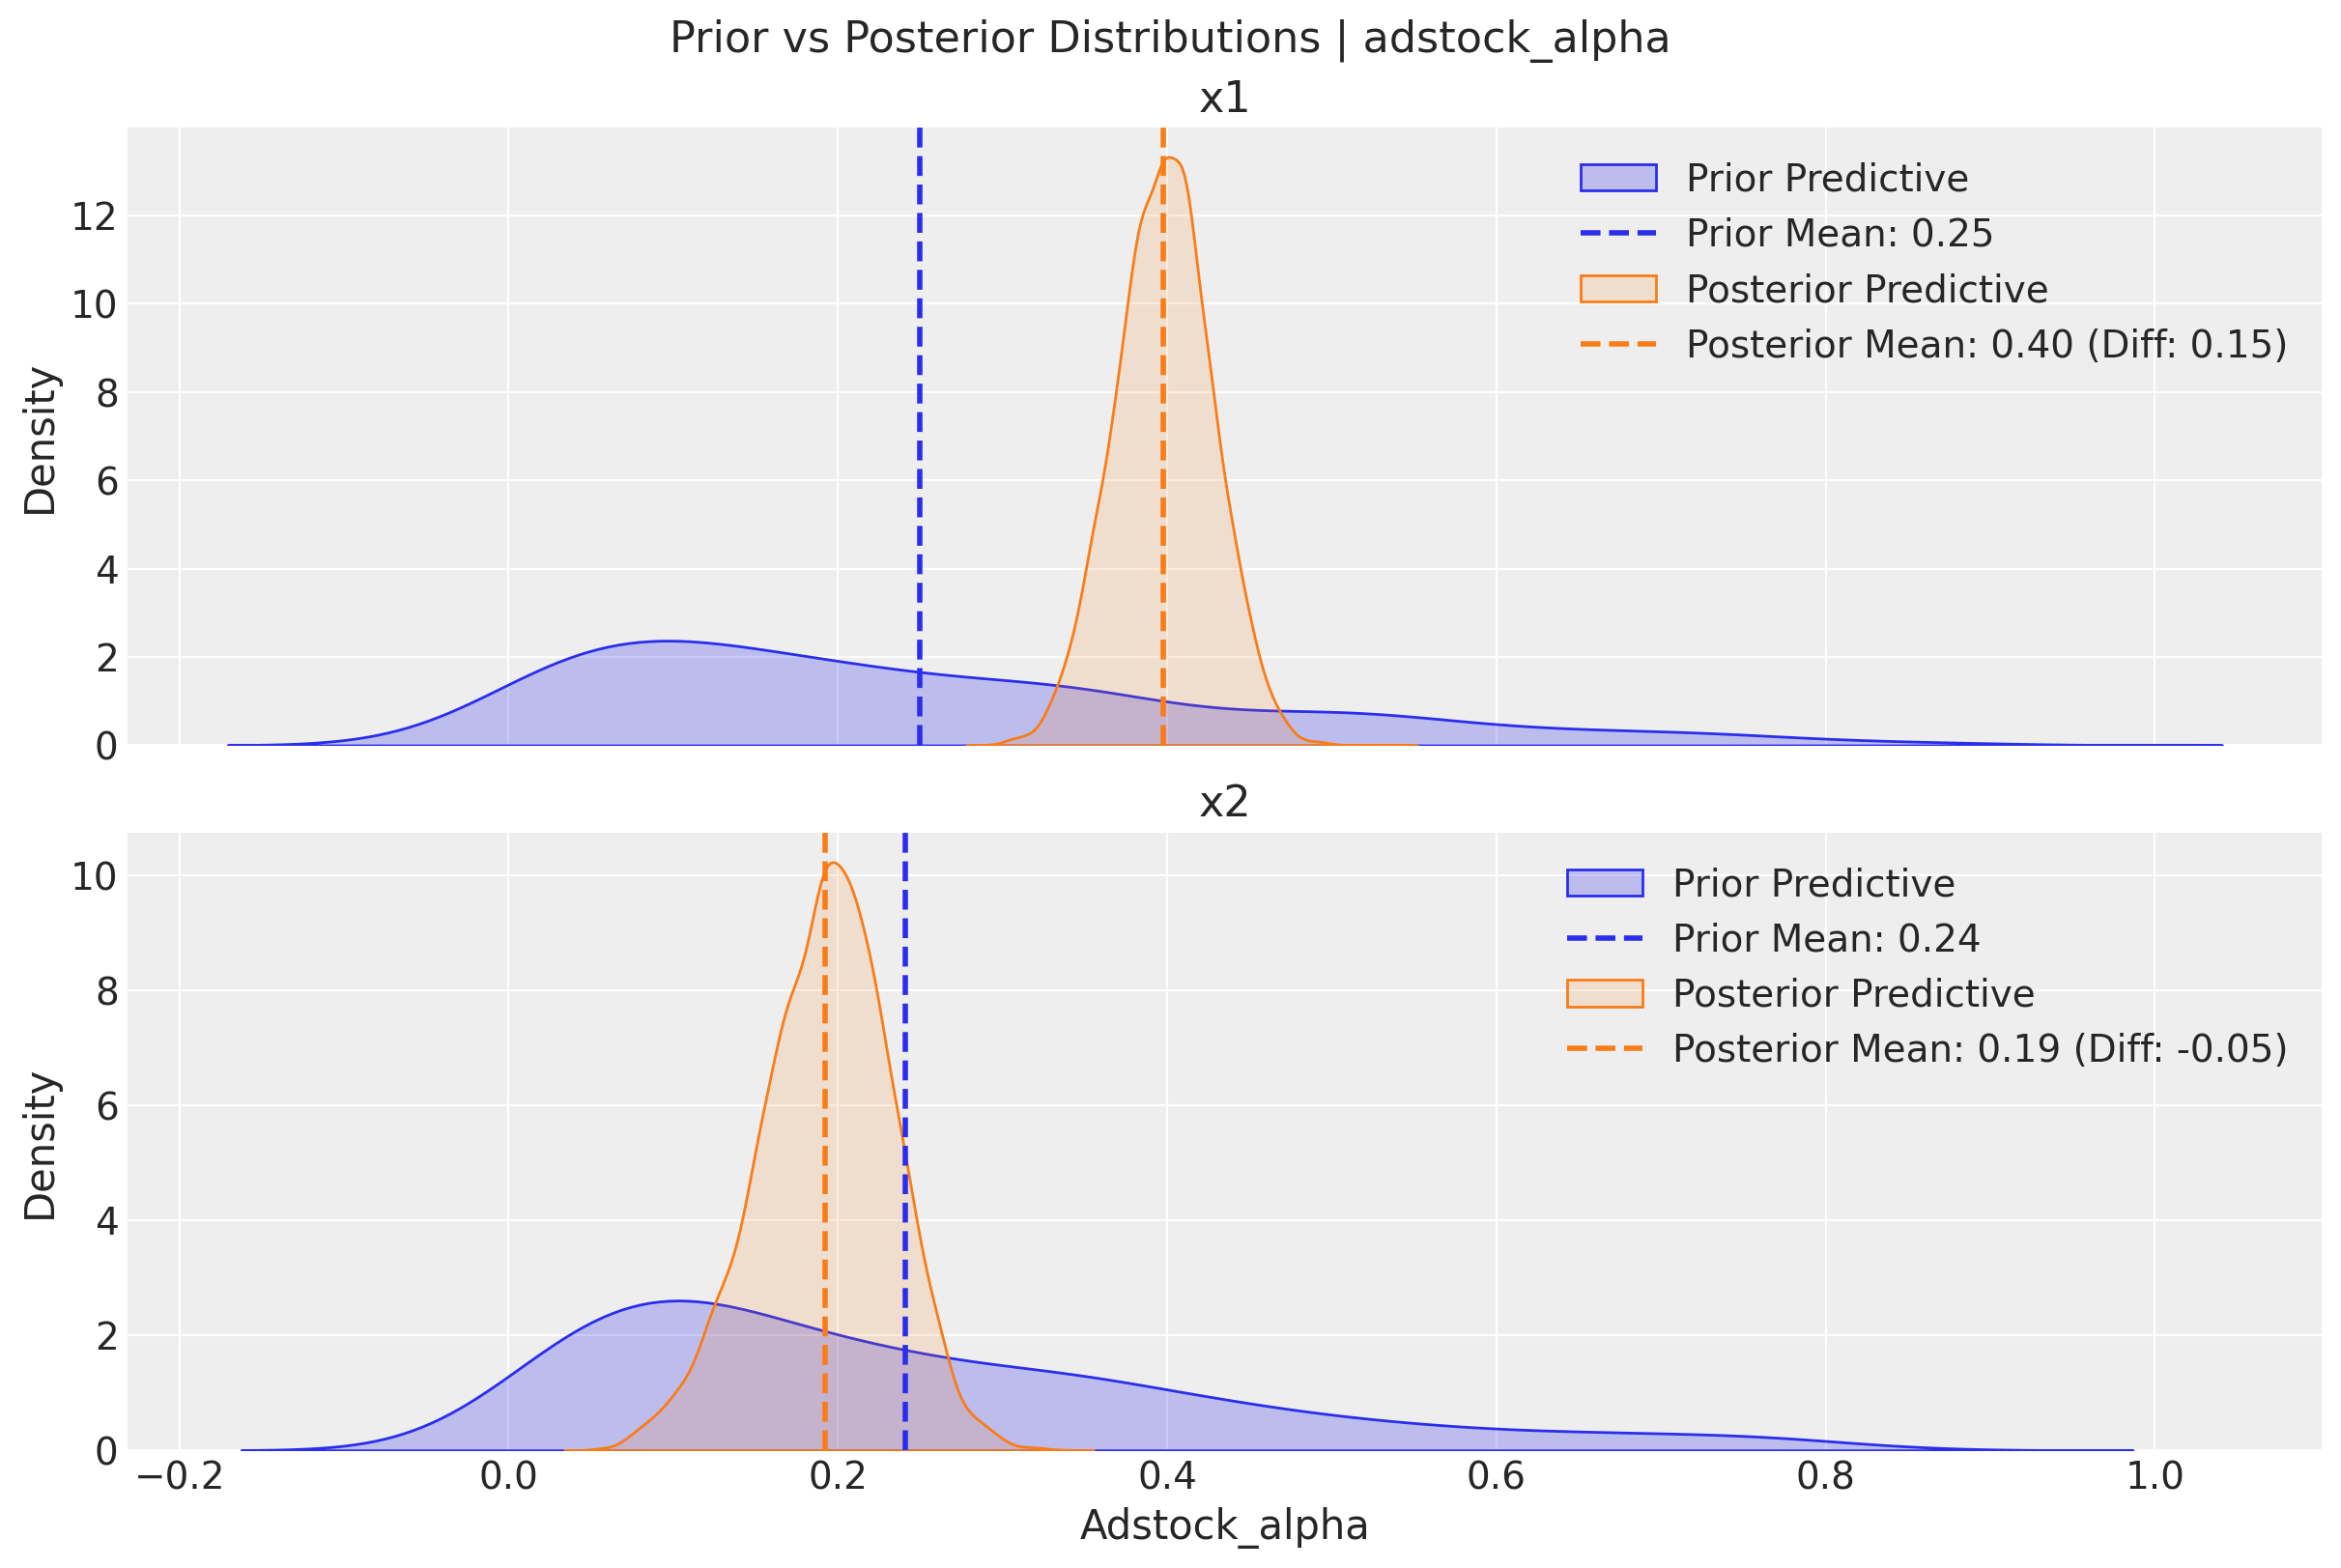

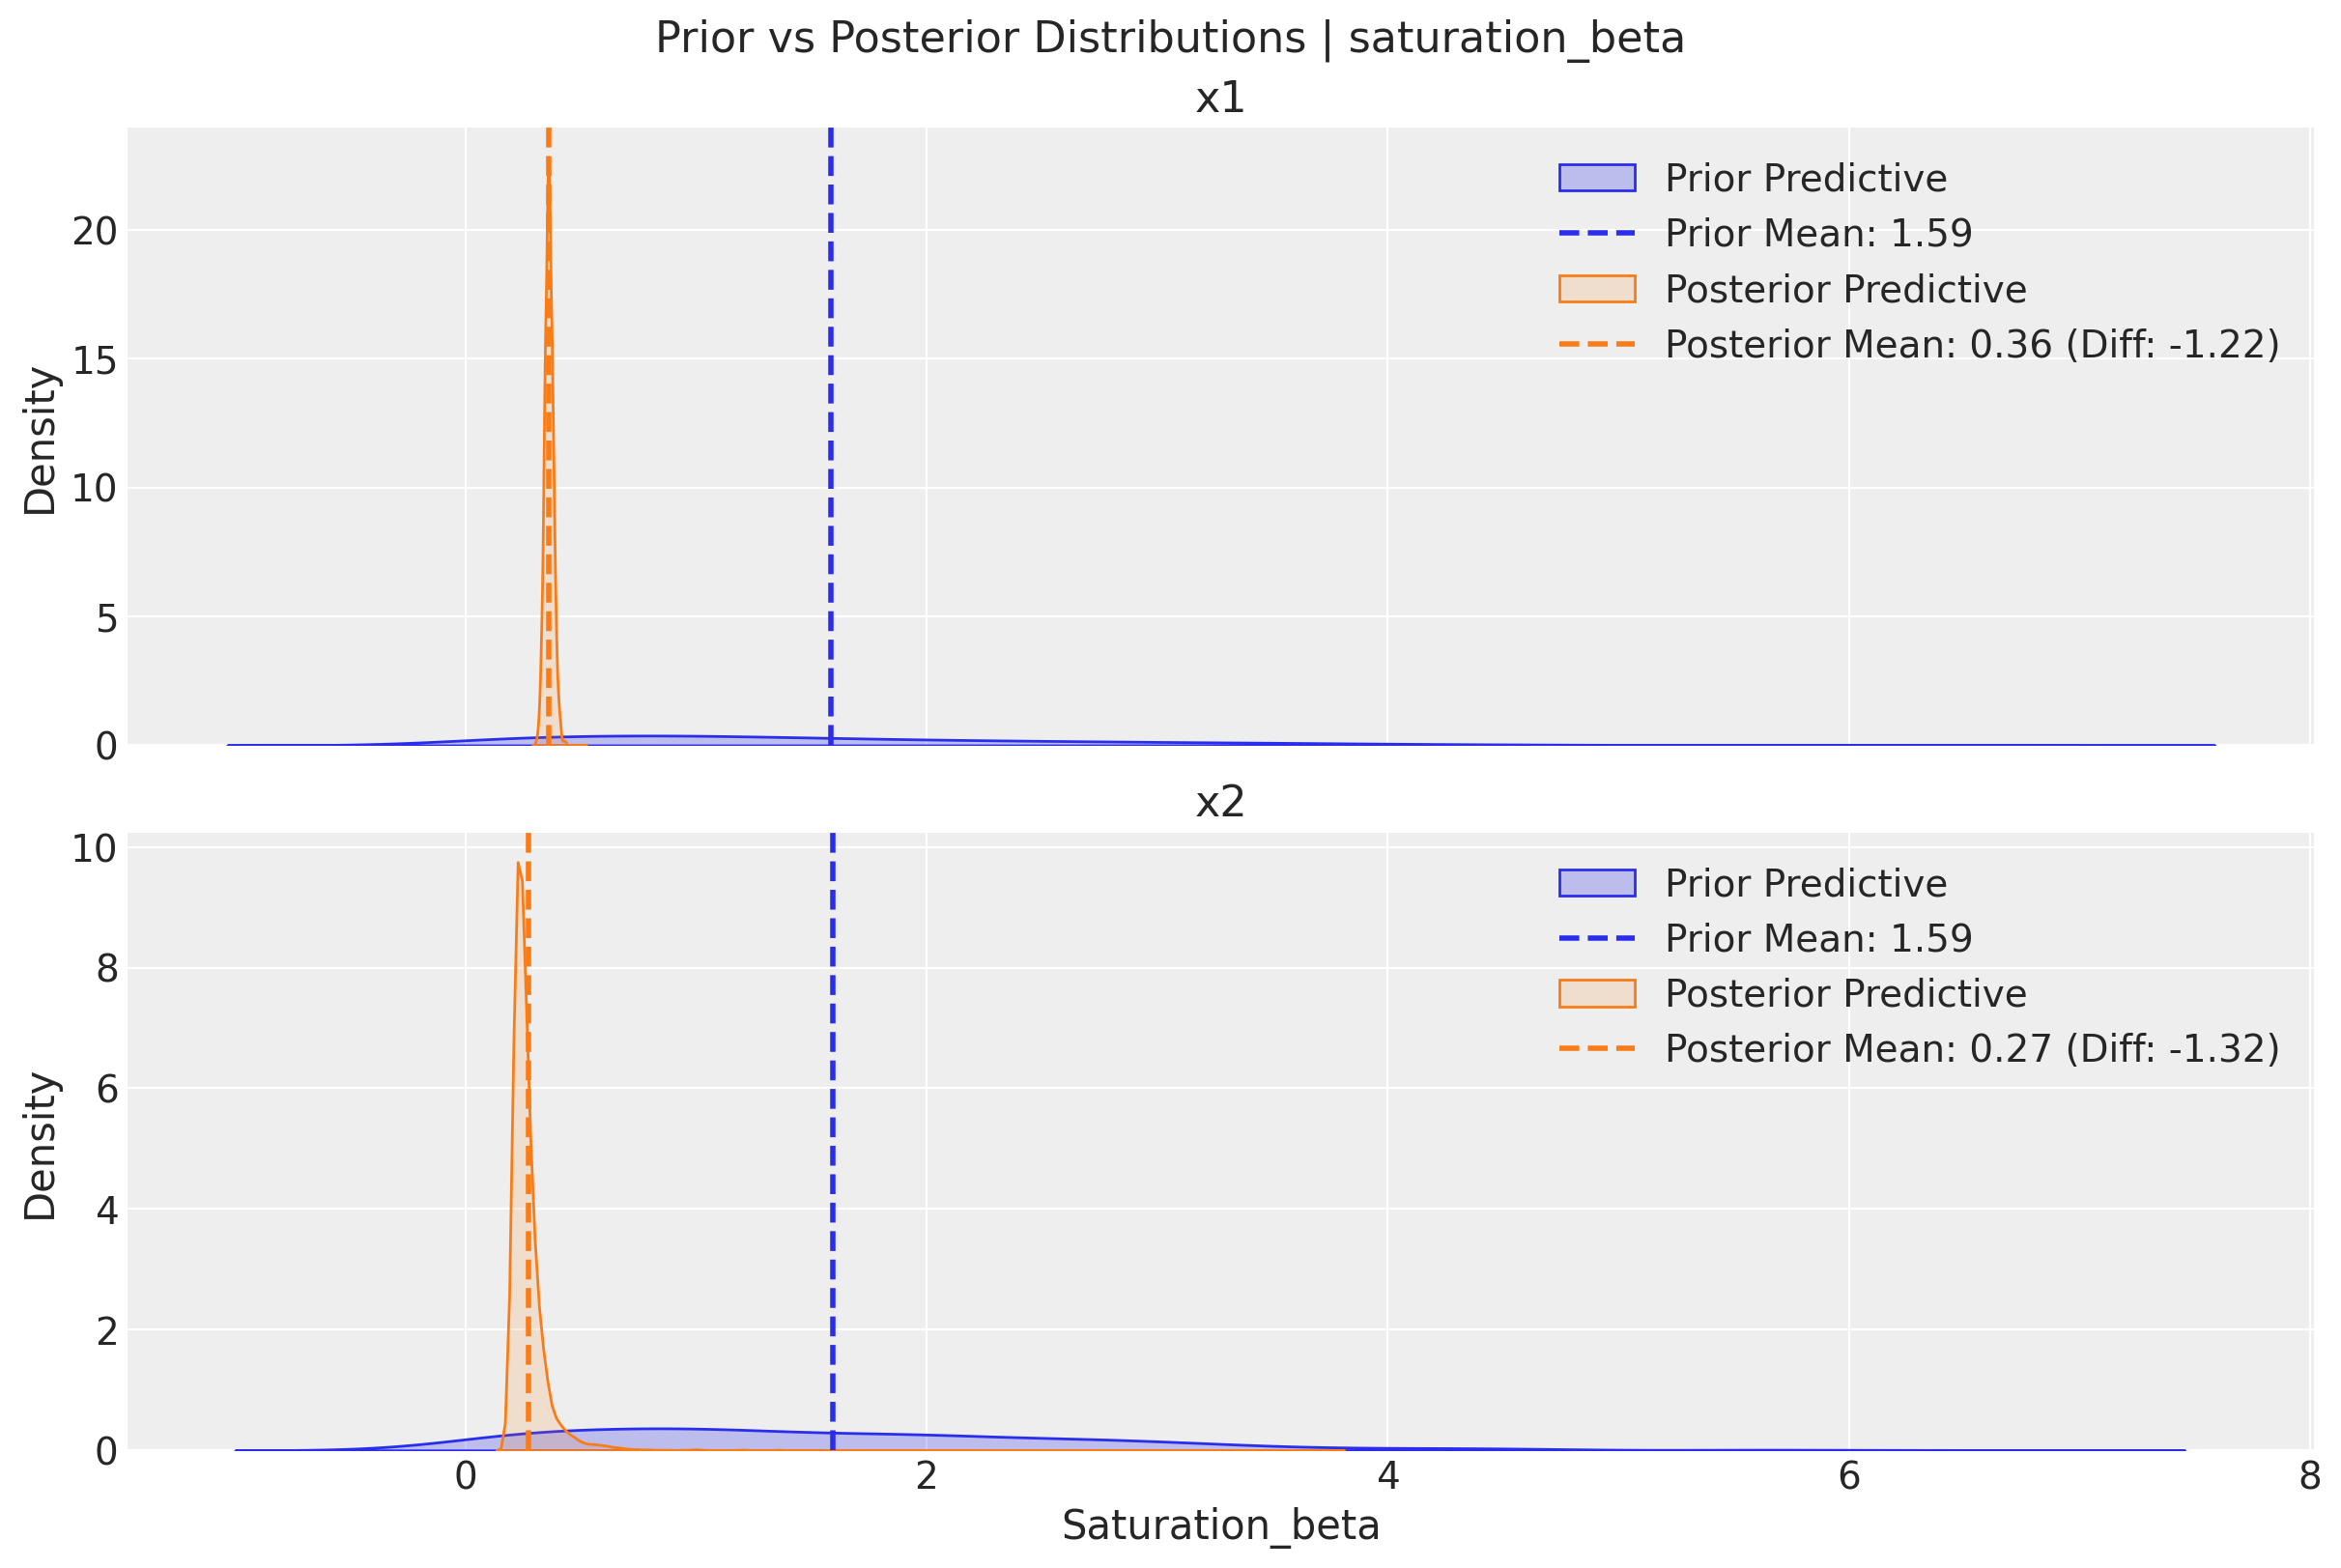

In [8]:
# First, sample from the prior
prior_preds = mmm.sample_prior_predictive(X, random_seed=rng)

# Plot prior vs posterior for adstock parameter
fig = mmm.plot_prior_vs_posterior(
    var_name="adstock_alpha",
    alphabetical_sort=True,  # Sort channels alphabetically
)

# Plot prior vs posterior for saturation parameter
fig = mmm.plot_prior_vs_posterior(
    var_name="saturation_beta",
    alphabetical_sort=False,  # Sort by difference between prior and posterior means
);

These visualizations help us understand:

1. How much we learned from the data (difference between prior and posterior)
2. The uncertainty in our parameter estimates (width of the distributions)
3. Whether our priors were reasonable (by comparing prior and posterior ranges)

The `plot_prior_vs_posterior` method allows us to sort channels either alphabetically or by the magnitude of change from prior to posterior, helping identify which channels had the strongest updates from the data.

## Conclusion

In this notebook, we've demonstrated how to:

1. Calculate various evaluation metrics for your MMM including normalized versions (NRMSE, NMAE), as both summaries and distributions
2. Visualize metric distributions for a chosen evaluation metric
3. Compare prior vs posterior distributions for different metrics

These tools help us understand model performance and uncertainty in our predictions, which is crucial for making informed marketing decisions.

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Tue Jan 14 2025

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

pymc_marketing: 0.10.0
pytensor      : 2.26.4

arviz         : 0.20.0
pymc_marketing: 0.10.0
matplotlib    : 3.10.0
sklearn       : 1.6.0
numpy         : 1.26.4
pandas        : 2.2.3

Watermark: 2.5.0

